
### 1. Data reading



First load and normalize our training and test data using `torchvision` .


In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary
from utils import show_examples, UnNormalize, train, plot_history, plot_confusion_matrix, compute_confusion_matrix

In [2]:
transform = transforms.Compose([
        transforms.Resize((32,32)),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(
     (0.1307,), (0.3081,))
]) 

In [3]:
Batch_Size = 64

In [4]:
trainset = datasets.MNIST(root='./data', train=True,download=True, transform=transform)
testset = datasets.MNIST(root='./data',train=False,download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_Size,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_Size,shuffle=True, num_workers=2)
classes = ('0', '1', '2', '3', '4','5', '6', '7', '8', '9')


### 2. View data (format, size, shape)


In [5]:
classes = trainset.classes
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [6]:
trainset.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}


### Summarize:

### 3. View pictures


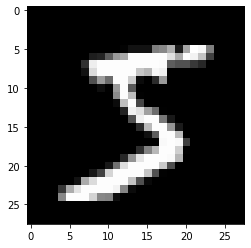

In [7]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(trainset.data[0], cmap="gray")
im ,label = iter(trainloader).next()

In [8]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

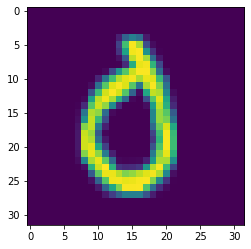

In [9]:
imshow(im[0])

In [10]:
im[0].shape

torch.Size([1, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


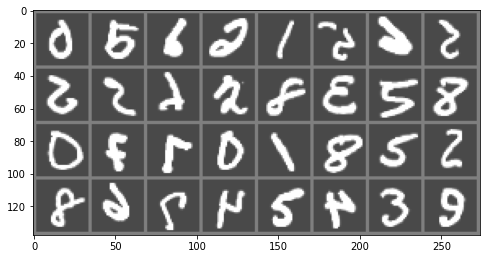

In [11]:
plt.figure(figsize=(8,12))
imshow(torchvision.utils.make_grid(im[:32]))


### 4. Define the network (GoogLeNet)



In order to avoid the problem of gradient disappearance caused by deep network training, the author also introduced two auxiliary classifiers. After the output of the third and sixth Inception modules, Softmax was performed and the loss was calculated. During training and the final loss of a and send back.

 Next, let&#39;s take a look at the auxiliary classifier structure. The two auxiliary classifier structures in the network are exactly the same, as shown in the following figure: 

![](https://img-blog.csdnimg.cn/216d41f8162b464c9d19ace3048506b8.png)

 Auxiliary Classifier:

```
第一层是一个平均池化下采样层，池化核大小为5x5，stride=3第二层是卷积层，卷积核大小为1x1，stride=1，卷积核个数是128第三层是全连接层，节点个数是1024第四层是全连接层，节点个数是1000（对应分类的类别个数）
```

 The parameter amount of Inception v1 is 1/12 of AlexNet and 1/3 of VGGNet, which is suitable for processing large-scale data, especially for platforms with limited computing resources.

 **Inception v2**

 Based on the Inception v1 network, multiple Inception versions have subsequently appeared. Inception v2 further achieves more efficient computation through convolution decomposition and regularization, adds a BN layer, and uses two cascaded 3×3 convolutions to replace the 5×5 convolutions in the Inception v1 version, as shown in Figure 3.15 , which not only reduces the amount of convolution parameters, but also increases the nonlinear ability of the network. 

![](https://img-blog.csdnimg.cn/0b4e8ee0797b48c790041c69d02fed70.png)

 In addition to these two versions, Inception v3 and Inception v4 have been released in recent years.

 On the basis of Inception v2, Inception v3 uses the RMSProp optimizer, adds a 7×7 convolution to the auxiliary classifier part, and uses the label smoothing technique.

 Inception v4 combines the idea of Inception with the residual network, which significantly improves the training speed and model accuracy. The details of the module will not be described here. As for the landmark structure of the residual network, it is derived from the network ResNet in the next section.

 **This demo only shows the network structure of Inception v1.** If you are interested, you can try other network structures.


Afin d'éviter le problème de disparition du gradient causé par l'apprentissage profond du réseau, l'auteur a également introduit deux classificateurs auxiliaires. Après la sortie des troisième et sixième modules Inception, Softmax a été exécuté et la perte a été calculée. Pendant la formation et la perte finale d'un et renvoyer.

 Examinons ensuite la structure du classificateur auxiliaire. Les deux structures de classificateurs auxiliaires du réseau sont exactement les mêmes, comme illustré dans la figure suivante :

![](https://img-blog.csdnimg.cn/216d41f8162b464c9d19ace3048506b8.png)

 Classificateur auxiliaire :

```
第一 层 是 一 个 平均 池化 下 采样层 ， 池化 核 大小 为 5x5 ， Stride = 3 第二 层 是 卷积层 ， 卷积核 大小 为 1x1 ， Stride = 1 ， 卷积 核 个数 是 128 第三层是全连接层，节点个数是1024第四层是全连接层，节点个数是1000（对应分类的类别个数）
```

 La quantité de paramètres d'Inception v1 est de 1/12 d'AlexNet et de 1/3 de VGGNet, ce qui convient au traitement de données à grande échelle, en particulier pour les plates-formes aux ressources informatiques limitées.

 **Inception v2**

 Basé sur le réseau Inception v1, plusieurs versions d'Inception sont apparues par la suite. Inception v2 réalise en outre un calcul plus efficace grâce à la décomposition et à la régularisation de la convolution, ajoute une couche BN et utilise deux convolutions 3 × 3 en cascade pour remplacer les convolutions 5 × 5 dans la version Inception v1, comme le montre la figure 3.15 , ce qui non seulement réduit le quantité de paramètres de convolution, mais augmente également la capacité non linéaire du réseau.

![](https://img-blog.csdnimg.cn/0b4e8ee0797b48c790041c69d02fed70.png)

 En plus de ces deux versions, Inception v3 et Inception v4 sont sorties ces dernières années.

 Sur la base d'Inception v2, Inception v3 utilise l'optimiseur RMSProp, ajoute une convolution 7×7 à la partie classificateur auxiliaire et utilise la technique de lissage des étiquettes.

 Inception v4 combine l'idée d'Inception avec le réseau résiduel, ce qui améliore considérablement la vitesse d'entraînement et la précision du modèle. Les détails du module ne seront pas décrits ici. Quant à la structure de repère du réseau résiduel, elle est dérivée du réseau ResNet dans la section suivante.

 **Cette démo ne montre que la structure réseau d'Inception v1.** Si vous êtes intéressé, vous pouvez essayer d'autres structures réseau.

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
# Define a convolution plus a relu activation function and a batchnorm as a basic layer structure
class BasicConv2d(nn.Module):
    def __init__(self,in_channel, out_channel, kernel_size, stride=1, padding=0):
        super(BasicConv2d,self).__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding)
        self.batch = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU(True)
    def forward(self, x):
        x = self.conv(x)
        x = self.batch(x)
        x = self.relu(x)
        return x

In [14]:
class Inception(nn.Module):
    def __init__(self, in_channel, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_proj):
        super(Inception, self).__init__()
        
        # first line
        self.branch1x1 = BasicConv2d(in_channel, n1x1, 1)
        
        # second line
        self.branch3x3 = nn.Sequential(
            BasicConv2d(in_channel, n3x3red, 1),
            BasicConv2d(n3x3red, n3x3, 3, padding=1)
        )
        
        # third line
        self.branch5x5 = nn.Sequential(
            BasicConv2d(in_channel, n5x5red, 1),
            BasicConv2d(n5x5red, n5x5, 5, padding=2)
        )
        
        # Fourth line
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channel, pool_proj, 1)
        )
    def forward(self, x):
        f1 = self.branch1x1(x)
        f2 = self.branch3x3(x)
        f3 = self.branch5x5(x)
        f4 = self.branch_pool(x)
        output = torch.cat((f1, f2, f3, f4), dim=1)
        return output

In [15]:
class InceptionAux(nn.Module):
    def __init__(self, in_channel, num_classes):
        super(InceptionAux, self).__init__()
#         self.averagePool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.averagePool = nn.AvgPool2d(kernel_size=2)
        self.conv = BasicConv2d(in_channel, 128, kernel_size=1)  # output[batch, 128, 4, 4]
        
        self.fc1 = nn.Sequential(
#             nn.Linear(2048, 1024),
            nn.Linear(128,64),
            nn.ReLU(True)
        )
#         self.drop = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(1024, num_classes)
        self.fc2 = nn.Linear(64, num_classes)
    def forward(self, x):

        x = self.averagePool(x)
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = F.dropout(x, 0.5, training=self.training)
        x = self.fc1(x)
        x = F.dropout(x, 0.5, training=self.training)
        x = self.fc2(x)
        return x

In [16]:
test_net = Inception(1, 64, 48, 64, 64, 96, 32)
test_x =torch.zeros(1, 1, 32, 32)
print('input shape: {} x {} x {}'.format(test_x.shape[1], test_x.shape[2], test_x.shape[3]))
test_y = test_net(test_x)
print('output shape: {} x {} x {}'.format(test_y.shape[1], test_y.shape[2], test_y.shape[3]))

input shape: 1 x 32 x 32
output shape: 256 x 32 x 32


In [17]:
class GoogLeNet(nn.Module):
    def __init__(self, in_channel, num_classes, aux_logits=False, verbose=False, init_weights=True):
        super(GoogLeNet, self).__init__()
        self.verbose = verbose
        self.aux_logits = aux_logits
        
#         self.block1 = nn.Sequential(
#             BasicConv2d(in_channel, out_channel=64, kernel=7, stride=2, padding=3),
#             nn.MaxPool2d(3, 2, ceil_mode=True)
#         )
        
#         self.block2 = nn.Sequential(
#             BasicConv2d(64, 64, kernel=1),
#             BasicConv2d(64, 192, kernel=3, padding=1),
#             nn.MaxPool2d(3, 2, ceil_mode=True)
#         )
        
#         self.block3 = nn.Sequential(
#             inception(192, 64, 96, 128, 16, 32, 32),
#             inception(256, 128, 128, 192, 32, 96, 64),
#             nn.MaxPool2d(3, 2, ceil_mode=True)
#         )
        
#         self.block4 = nn.Sequential(
#             inception(480, 192, 96, 208, 16, 48, 64),
#             inception(512, 160, 112, 224, 24, 64, 64),
#             inception(512, 128, 128, 256, 24, 64, 64),
#             inception(512, 112, 144, 288, 32, 64, 64),
#             inception(528, 256, 160, 320, 32, 128, 128),
#             nn.MaxPool2d(3, 2, ceil_mode=True)
#         )
        
#         self.block5 = nn.Sequential(
#             inception(832, 256, 160, 320, 32, 128, 128),
#             inception(832, 384, 182, 384, 48, 128, 128),
            
#         )
        # block1
        self.conv1 = BasicConv2d(1, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        # block2
        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        # block3
        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        # block4
        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        # block5
        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)
        
        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)
        
#         self.avgpool = nn.AvgPool2d(7)
        self.avgpool = nn.AvgPool2d(1) # 对32x32 不一样
        self.dropout = nn.Dropout(0.4)
        self.classifier = nn.Linear(1024, num_classes)
        if init_weights:
            self._initialize_weights()
        
            
    def forward(self, x):
#         x = self.block1(x)
        x = self.conv1(x)
        x = self.maxpool1(x)
        if self.verbose:
            print('block 1 output: {}'.format(x.shape))
#         x = self.block2(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool2(x)
        if self.verbose:
            print('block 2 output: {}'.format(x.shape))
#         x = self.block3(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        if self.verbose:
            print('block 3 output: {}'.format(x.shape))
#         x = self.block4(x)
        x = self.inception4a(x)
        if self.training and self.aux_logits:    # eval model lose this layer
            aux1 = self.aux1(x)
            if self.verbose:
                print('aux 1 output: {}'.format(aux1.shape))
            
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        if self.training and self.aux_logits:    # eval model lose this layer
            aux2 = self.aux2(x)
            if self.verbose:
                print('aux 2 output: {}'.format(aux2.shape))
        x = self.inception4e(x)
        x = self.maxpool4(x)
        if self.verbose:
            print('block 4 output: {}'.format(x.shape))
#         x = self.block5(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        if self.verbose:
            print('block 5 output: {}'.format(x.shape))
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.dropout(x)
        x = self.classifier(x)
        if self.training and self.aux_logits:   # eval model lose this layer
            return x, aux2, aux1
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [18]:
net = GoogLeNet(1,10,aux_logits = True, verbose = False).to(device)

In [19]:
summary(net,(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           3,200
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
       BasicConv2d-4           [-1, 64, 16, 16]               0
         MaxPool2d-5             [-1, 64, 8, 8]               0
            Conv2d-6             [-1, 64, 8, 8]           4,160
       BatchNorm2d-7             [-1, 64, 8, 8]             128
              ReLU-8             [-1, 64, 8, 8]               0
       BasicConv2d-9             [-1, 64, 8, 8]               0
           Conv2d-10            [-1, 192, 8, 8]         110,784
      BatchNorm2d-11            [-1, 192, 8, 8]             384
             ReLU-12            [-1, 192, 8, 8]               0
      BasicConv2d-13            [-1, 192, 8, 8]               0
        MaxPool2d-14            [-1, 19

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:781: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [20]:
print(net)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (batch): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (batch): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1x1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (batch): 

In [21]:
test_net = GoogLeNet(1, 10, aux_logits = True,verbose = True)
test_x = torch.zeros(3, 1, 32, 32)
test_net.train
test_y = test_net(test_x)
print('output: {}'.format(test_y[0].shape))

block 1 output: torch.Size([3, 64, 8, 8])
block 2 output: torch.Size([3, 192, 4, 4])
block 3 output: torch.Size([3, 480, 2, 2])
aux 1 output: torch.Size([3, 10])
aux 2 output: torch.Size([3, 10])
block 4 output: torch.Size([3, 832, 1, 1])
block 5 output: torch.Size([3, 1024, 1, 1])
output: torch.Size([3, 10])


In [22]:
net = GoogLeNet(1,10,aux_logits=True).to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    # When the calculation graph does not change (the input shape is the same each time, the model does not change), the performance can be improved, otherwise the performance will be reduced
    torch.backends.cudnn.benchmark=True


### 5. Define the loss function and optimizer


In [23]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5 ,patience = 5,min_lr = 0.000001) # 动态更新学习率
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 150], gamma=0.5)
import time
epoch = 20


### 6. Training

 If there is no accident, an error will be reported, because the input picture size in the 22-layer structure is 32x32, but in a series of intermediate calculations, the 32x32 picture size will appear in a certain link. The size of the calculation result is 0x0, so Mismatch.

 But in order to be the same as the paper, I changed all of them to 3x224x224 in the transform of the data, so no error will be reported.

 If we want to use 3x32x32, we may need to modify our average pooling layer

 I&#39;m using 32x32x3 here


In [24]:
import os
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('The file already exists')
save_path = './model/GoogLeNet.pth'

The file already exists


In [25]:
import time
best_acc = 0
train_acc_list, test_acc_list = [],[]
train_loss_list, test_loss_list = [],[]
lr_list = []
for i in range(epoch):
    start = time.time()
    train_loss = 0
    train_acc = 0
    test_loss = 0
    test_acc = 0
    if torch.cuda.is_available():
        net = net.to(device)
    net.train()
    for step,data in enumerate(trainloader,start=0):
        im,label = data
        im = im.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        logits, aux_logits2, aux_logits1 = net(im)
        loss0 = criterion(logits, label)
        loss1 = criterion(aux_logits1, label)
        loss2 = criterion(aux_logits2, label)
        loss = loss0 + loss1 *0.3 + loss2* 0.3
        loss.backward()
        optimizer.step()
        outputs = logits
        train_loss += loss.data
        probs, pred_y = outputs.data.max(dim=1) # get the probability
        train_acc += (pred_y==label).sum()/label.size(0)

        rate = (step + 1) / len(trainloader)
        a = "*"* int(rate *50)
        b = "."* (50 - int(rate *50))
        print('\r train {:3d}|{:3d} {:^3.0f}% [{}->{}] '.format(i+1,epoch,int(rate*100),a ,b),end='')

    train_loss = train_loss / len(trainloader)
    train_acc = train_acc*100 / len(trainloader)
# print('train_loss:{:.3f} train_acc:{:3.2f}%' .format(train_loss ,train_acc),end=' ')
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    lr = optimizer.param_groups[0]['lr']
    lr_list.append(lr)
    scheduler.step(train_loss)
    
    net.eval()
    with torch.no_grad():
        for step,data in enumerate(testloader,start=0):
            im,label = data
            im = im.to(device)
            label = label.to(device)
            outputs = net(im)
            loss = criterion(outputs,label)
            test_loss += loss.data
            probs, pred_y = outputs.data.max(dim=1) # get the probability
            test_acc += (pred_y==label).sum()/label.size(0)
            rate = (step + 1) / len(testloader)
            a = "*" *int(rate* 50)
            b = "." *(50 - int(rate* 50))
            print('\r test {:3d}|{:3d} {:^3.0f}% [{}->{}] '.format(i+1,epoch,int(rate*100),a ,b),end='')
    test_loss = test_loss / len(testloader)
    test_acc = test_acc* 100 /len(testloader)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    end = time.time()
    print('\rEpoch [{:>3d}/{:>3d}]  Train Loss:{:>.6f}  Train Acc:{:>3.2f}% Test Loss:{:>.6f}  Test Acc:{:>3.2f}%  Learning Rate:{:>.6f}'.format(
                    i + 1, epoch, train_loss, train_acc, test_loss, test_acc,lr), end='')
    time_= int(end - start)
    time_ = int(end - start)
    h = time_/ 3600
    m = time_% 3600/60
    s = time_% 60
    time_str = "\tTime %02d:%02d" % ( m, s)
    # print elapsed time
    print(time_str)
    # If you get better accuracy, save the model
    if test_acc > best_acc:
        torch.save(net,save_path)
        best_acc = test_acc

Acc = {}
Loss = {}
Acc['train_acc'] = train_acc_list
Acc['test_acc'] = test_acc_list
Loss['train_loss'] = train_loss_list
Loss['test_loss'] = test_loss_list
Lr = lr_list



Epoch [  1/ 20]  Train Loss:0.938526  Train Acc:90.66% Test Loss:0.081285  Test Acc:97.48%  Learning Rate:0.010000	Time 00:57
Epoch [  2/ 20]  Train Loss:0.205739  Train Acc:97.33% Test Loss:0.056611  Test Acc:98.33%  Learning Rate:0.010000	Time 00:53
Epoch [  3/ 20]  Train Loss:0.139852  Train Acc:98.06% Test Loss:0.064223  Test Acc:97.86%  Learning Rate:0.010000	Time 00:52
Epoch [  4/ 20]  Train Loss:0.111496  Train Acc:98.46% Test Loss:0.054710  Test Acc:98.34%  Learning Rate:0.010000	Time 00:53
Epoch [  5/ 20]  Train Loss:0.098122  Train Acc:98.63% Test Loss:0.041679  Test Acc:98.66%  Learning Rate:0.010000	Time 00:52
Epoch [  6/ 20]  Train Loss:0.086960  Train Acc:98.79% Test Loss:0.036209  Test Acc:98.82%  Learning Rate:0.010000	Time 00:52
Epoch [  7/ 20]  Train Loss:0.078976  Train Acc:98.93% Test Loss:0.033374  Test Acc:98.94%  Learning Rate:0.010000	Time 00:51
Epoch [  8/ 20]  Train Loss:0.073511  Train Acc:99.01% Test Loss:0.037965  Test Acc:98.83%  Learning Rate:0.010000	Tim

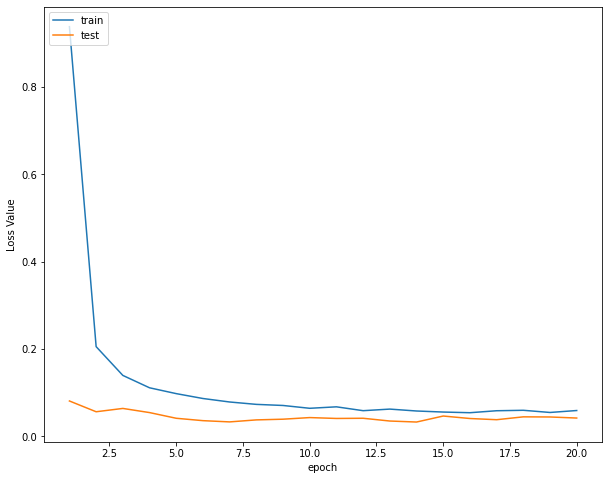

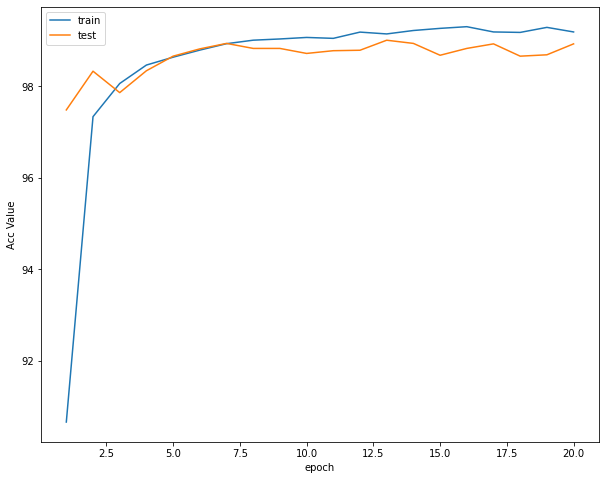

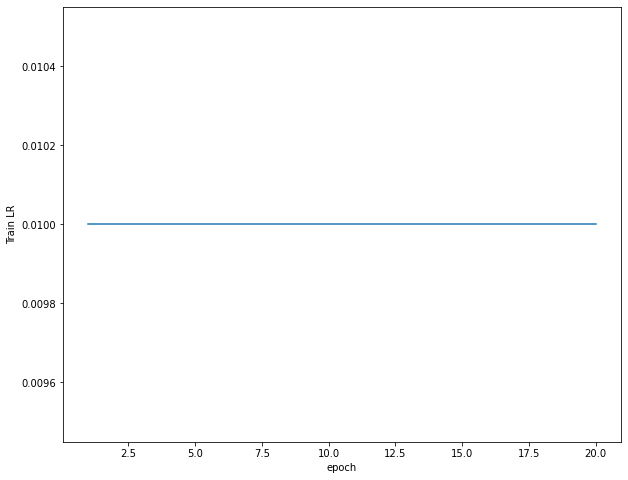

In [27]:
train_loss, test_loss = Loss['train_loss'], Loss['test_loss']
train_acc, test_acc = Acc['train_acc'], Acc['test_acc']
train_loss = [i.to('cpu') for i in train_loss]
test_loss = [i.to('cpu') for i in test_loss]
train_acc = [i.to('cpu') for i in train_acc]
test_acc = [i.to('cpu') for i in test_acc]
Acc['train_acc'] = train_acc
Acc['test_acc'] = test_acc
Loss['train_loss'] = train_loss
Loss['test_loss'] = test_loss
plot_history(epoch, Acc, Loss, Lr)

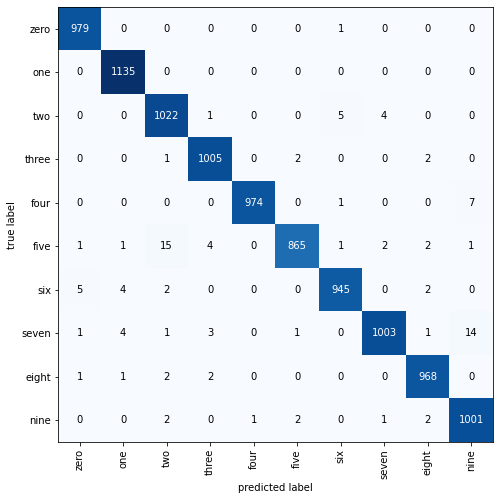

In [28]:
class_dict = {0: 'zero',
              1: 'one',
              2: 'two',
              3: 'three',
              4: 'four',
              5: 'five',
              6: 'six',
              7: 'seven',
              8: 'eight',
              9: 'nine'}

mat = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()


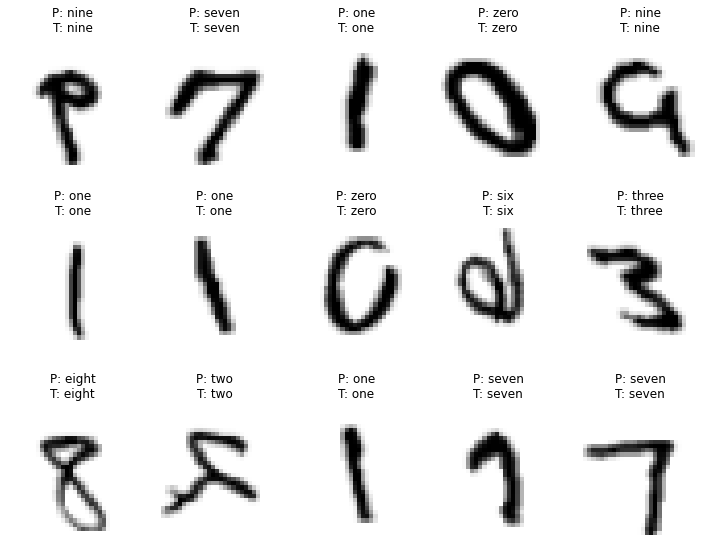

In [29]:
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=net, data_loader=testloader, unnormalizer=unnormalizer, class_dict=class_dict)


### 7. Test


In [31]:
correct = 0 # Define the number of correctly predicted images, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
# testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader: # Loop through each batch
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        net.eval() # Convert the model to test mode
        if hasattr(torch.cuda, 'empty_cache'):
                torch.cuda.empty_cache()
        outputs = net(images) # Enter the network for testing

        # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # update the number of test images
        correct += (predicted == labels).sum() # update the number of correctly classified images

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 98.94 %


In [33]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of 0 - zero : 100.00 %
Accuracy of 1 - one : 99.82 %
Accuracy of 2 - two : 99.22 %
Accuracy of 3 - three : 99.31 %
Accuracy of 4 - four : 98.98 %
Accuracy of 5 - five : 97.20 %
Accuracy of 6 - six : 98.12 %
Accuracy of 7 - seven : 97.47 %
Accuracy of 8 - eight : 99.28 %
Accuracy of 9 - nine : 99.21 %


Accuracy Rate = 100.0%


<Figure size 1800x288 with 0 Axes>

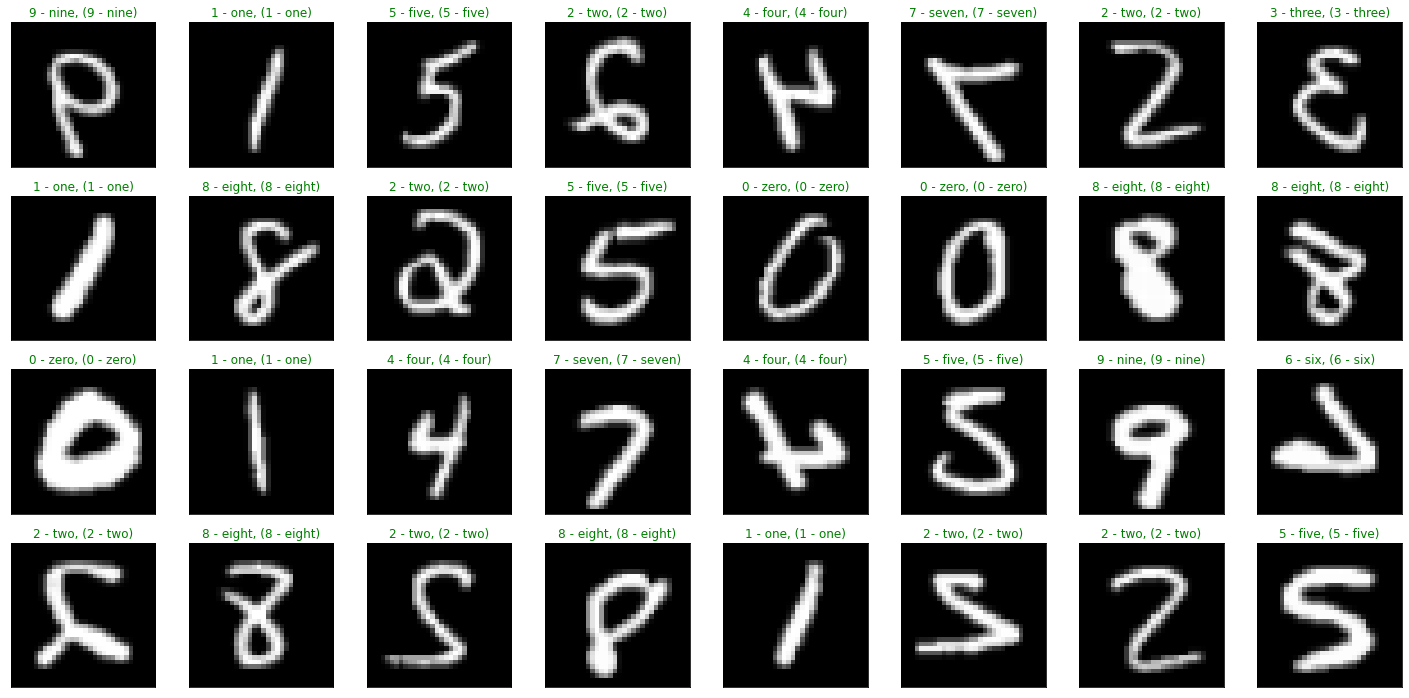

In [34]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images_ = images
#images_ = images_.view(images.shape[0], -1)
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(32):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    #fig.tight_layout()
#     plt.imshow(im_convert(images[idx]))
    imshow(images[idx])
    ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))

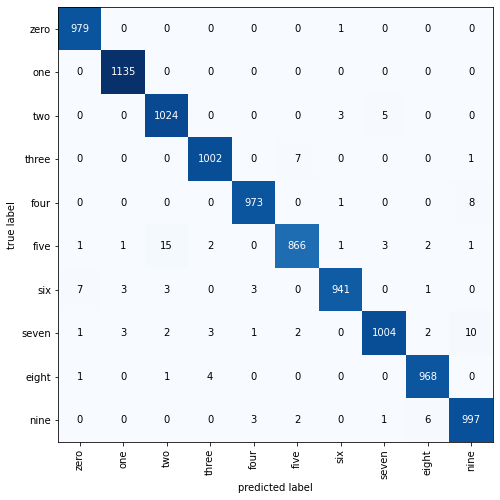

In [35]:
class_dict = {0: 'zero',
              1: 'one',
              2: 'two',
              3: 'three',
              4: 'four',
              5: 'five',
              6: 'six',
              7: 'seven',
              8: 'eight',
              9: 'nine'}

mat = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

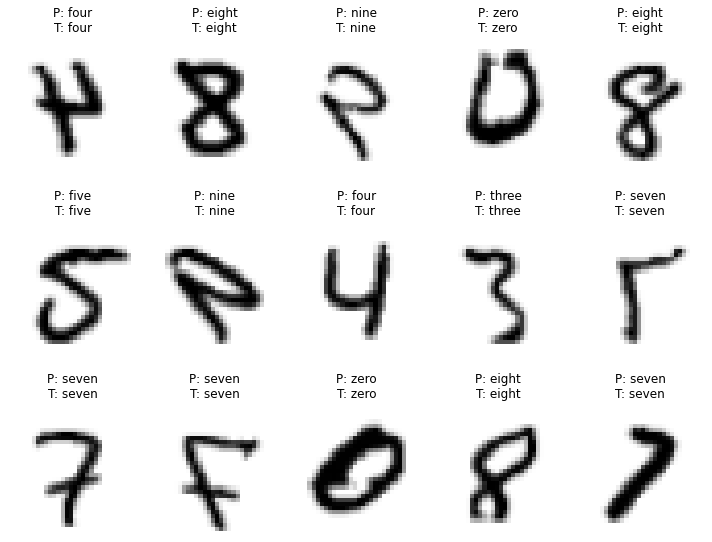

In [37]:
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=net.to('cuda'), data_loader=testloader, unnormalizer=unnormalizer, class_dict=class_dict)


### 8. Save the model


In [38]:
torch.save(net,save_path[:-4]+str(epoch)+'.pth')
# torch.save(net, './model/GoogLeNet-256.pth')

In [42]:
train_loss, test_loss = Loss['train_loss'], Loss['test_loss']
train_acc, test_acc = Acc['train_acc'], Acc['test_acc']
train_loss = [float(i) for i in train_loss]
test_loss = [float(i) for i in test_loss]
train_acc = [float(i) for i in train_acc]
test_acc = [float(i) for i in test_acc]
Acc['train_acc'] = train_acc
Acc['test_acc'] = test_acc
Loss['train_loss'] = train_loss
Loss['test_loss'] = test_loss

In [43]:
Acc

{'train_acc': [90.66497802734375,
  97.33475494384766,
  98.05937194824219,
  98.46248626708984,
  98.63406372070312,
  98.78897857666016,
  98.92890930175781,
  99.00553131103516,
  99.03218841552734,
  99.06549835205078,
  99.0455093383789,
  99.1821060180664,
  99.14212799072266,
  99.21708679199219,
  99.26372528076172,
  99.30037689208984,
  99.18544006347656,
  99.17544555664062,
  99.28538513183594,
  99.18544006347656],
 'test_acc': [97.48208618164062,
  98.3280258178711,
  97.86027526855469,
  98.33798217773438,
  98.65644836425781,
  98.81568908691406,
  98.93511199951172,
  98.82563781738281,
  98.82563781738281,
  98.7161636352539,
  98.77587890625,
  98.78582763671875,
  99.00477600097656,
  98.93511199951172,
  98.67635345458984,
  98.82563781738281,
  98.92516326904297,
  98.65644836425781,
  98.68630981445312,
  98.92516326904297]}

In [44]:
Loss

{'train_loss': [0.9385256767272949,
  0.20573855936527252,
  0.1398521214723587,
  0.11149566620588303,
  0.0981217548251152,
  0.08696004748344421,
  0.07897580415010452,
  0.07351101189851761,
  0.07098876684904099,
  0.06452731043100357,
  0.06789594888687134,
  0.059059154242277145,
  0.06268669664859772,
  0.05834437161684036,
  0.05593537911772728,
  0.05441141128540039,
  0.05892414599657059,
  0.05996502935886383,
  0.054986290633678436,
  0.05942457169294357],
 'test_loss': [0.08128507435321808,
  0.05661066621541977,
  0.06422308087348938,
  0.05470984801650047,
  0.04167875275015831,
  0.036209285259246826,
  0.03337438032031059,
  0.03796488046646118,
  0.0395667664706707,
  0.043259650468826294,
  0.041263241320848465,
  0.04169103503227234,
  0.0353732593357563,
  0.033066462725400925,
  0.046810444444417953,
  0.04113748297095299,
  0.03838903829455376,
  0.044950347393751144,
  0.04464593157172203,
  0.042206645011901855]}